In [1]:
import numpy as np
from gradvi.normal_means import NormalMeans, NormalMeansFromPosterior
from gradvi.models import basis_matrix
from gradvi.tests import toy_priors, toy_data

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

# Local imports
import tf_data
import tf_methods
import utils

In [2]:
def wavelet_func(W, y, z, s2, prior, jac = True, dj = None,
                 invert_method = 'trisection', invert_options = {}):
    """
    Calculate the objective function and its gradients with respect to the parameters
    """
    b = np.dot(W, z)
    sj2 = s2 / dj

    r = y - z
    rTr = np.dot(r, r)

    nm = NormalMeansFromPosterior(
            b, prior, sj2,
            scale = s2, d = dj,
            method = invert_method, **invert_options)

    Pb, dPdb, dPdw, dPdsj2 = nm.penalty_operator(jac = True)
    dPds2 = dPdsj2 / dj

    h     = (0.5 * rTr / s2) + np.sum(Pb)
    if jac:
        dhdx  = - r / s2 + np.dot(W.T, dPdb)
        dhdw  = np.sum(dPdw, axis = 0)
        dhda  = prior.wmod_grad(dhdw)
        dhds2 = - 0.5 * rTr / (s2 * s2) + np.sum(dPds2)
        return h, dhdx, dhda, dhds2
    return h

In [46]:
import collections

CData = collections.namedtuple('CData', ['x', 'y', 'ytest', 'ytrue', 'btrue', 'bspline_bases', 'bsp_beta'])

def gold_data(x, prior, nknots, strue, degree, seed = 100):
    n  = x.shape[0]
    scale_fact = np.power(n, degree) / np.math.factorial(degree)
    H  = basis_matrix.trendfiltering(n, degree) / scale_fact
    dj = np.sum(np.square(H), axis = 0)
    s2 = np.square(strue)
    # get NM responses
    z, sj2 = toy_data.get_normal_means(prior, n = n, s2 = s2, dj = dj, seed = seed)
    nm1 = NormalMeans(z, prior, sj2, scale = s2, d = dj)
    # get posterior mean
    b   = nm1.analytical_posterior_mean
    ytrue = np.dot(H, b)
    noise = np.random.normal(0, strue, size = n * 2)
    y = ytrue + noise[:n]
    ytest = ytrue + noise[n:]
    data = CData(x = x, y = y, ytest = ytest, ytrue = ytrue, btrue = b,
                 bspline_bases = None, bsp_beta = None)
    return data

In [53]:
n = 128
x = np.linspace(0, 1, n)
np.random.seed(100)

degrees = [0, 2, 3]
nknots  = 4
strue = 0.1
prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = 20.0)

data = dict()

for degree in degrees:
    data[degree] = gold_data(x, prior, nknots, strue, degree = degree, seed = 100)

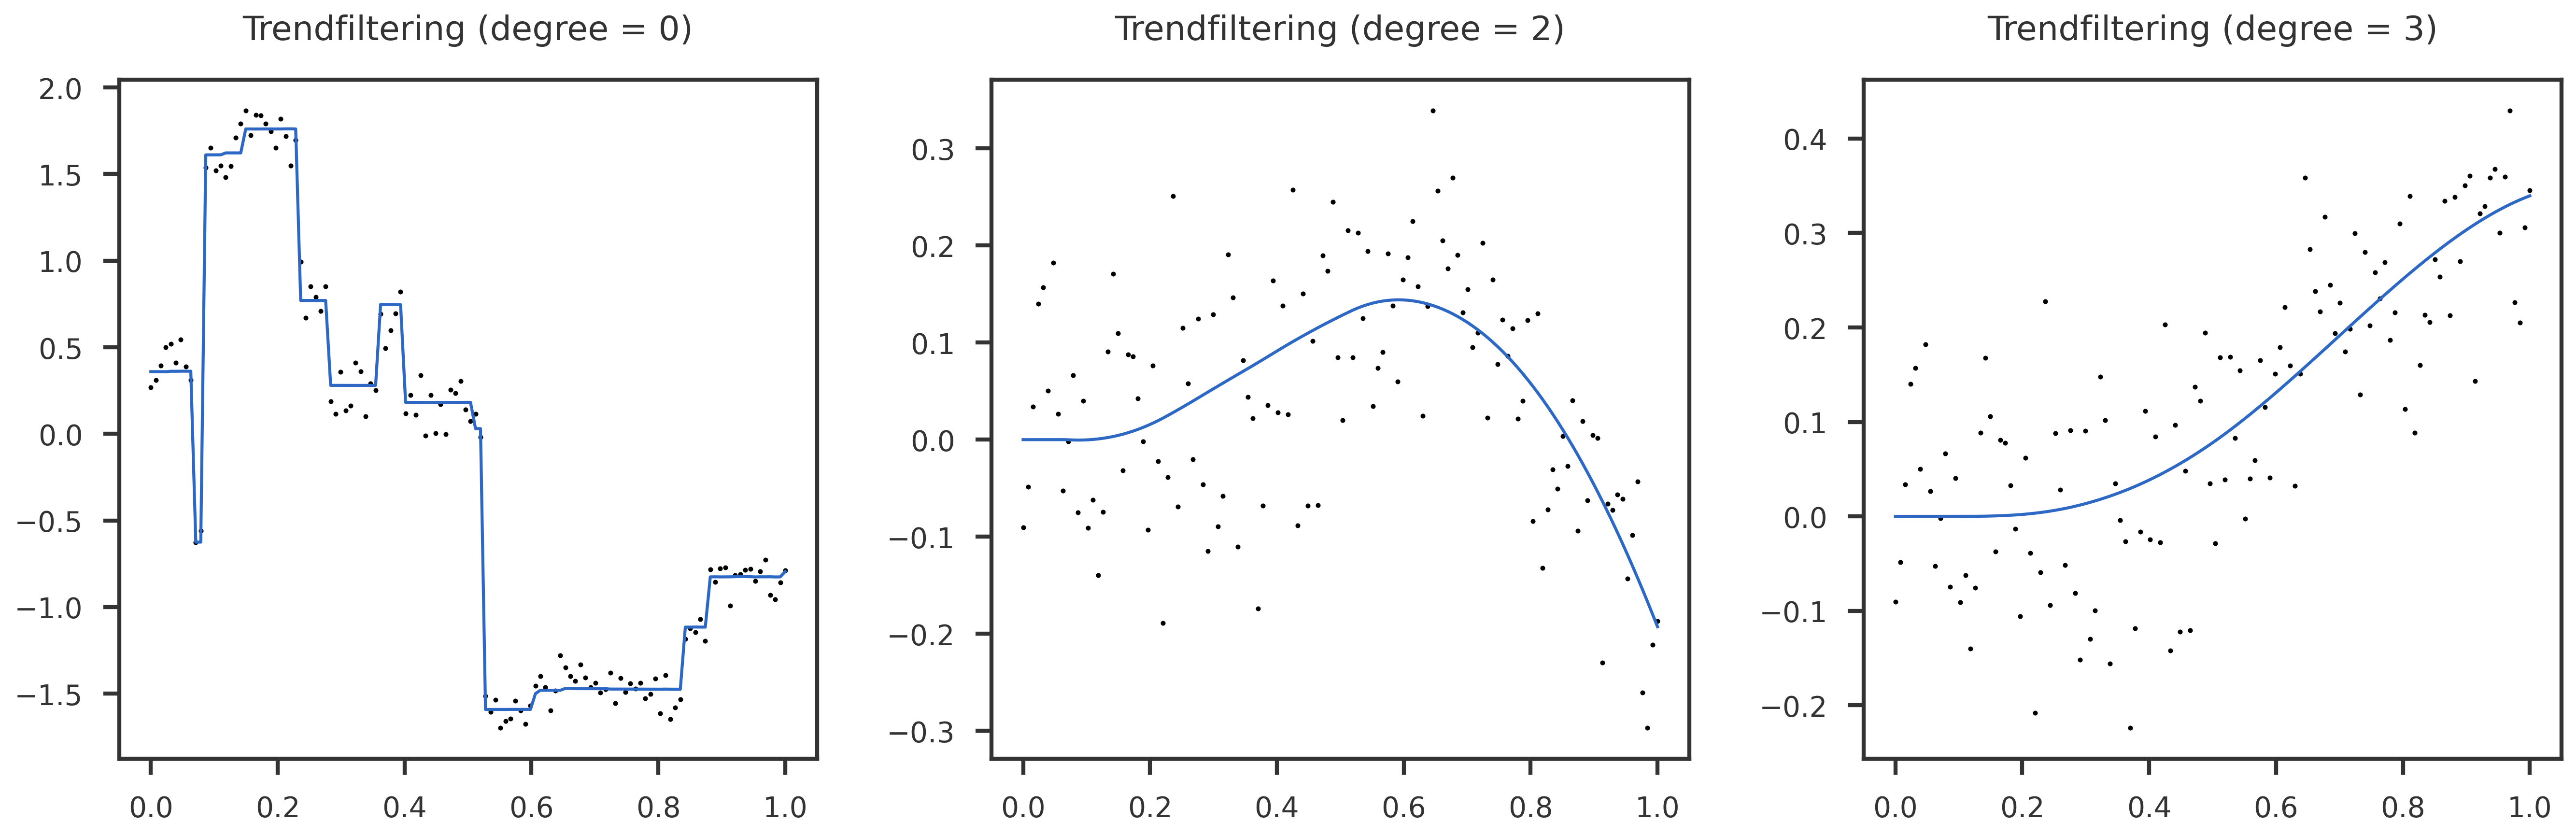

In [54]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue)
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.show()

### Check derivatives

In [55]:
from gradvi.tests import toy_priors
from gradvi.tests.derivative import numerical_derivative
from gradvi.optimize.moving_average import moving_average
from gradvi.models import LinearModel

h  =  {k: dict() for k in degrees}
dha = {k: dict() for k in degrees}
dhn = {k: dict() for k in degrees}

methods = ['analysis', 'synthesis']
for dk in degrees:
    for meth in methods:
        h[dk][meth] = 0
        dha[dk][meth] = {k: 0 for k in ['x', 'w', 's2']}
        dhn[dk][meth] = {k: 0 for k in ['x', 'w', 's2']}

for dk in degrees:
    
    scale_fact = np.power(n, dk) / np.math.factorial(dk)
    H      = basis_matrix.trendfiltering(n, dk) / scale_fact
    Hinv   = basis_matrix.trendfiltering_inverse(n, dk) * scale_fact
    dj     = np.sum(np.square(H), axis = 0)
    s2true = np.square(strue)
    
    #x0 = moving_average(data[dk].y, n = 40)
    x0 = data[dk].ytrue
    b0 = np.dot(Hinv, x0)
    np.testing.assert_allclose(data[dk].btrue, b0, atol = 1e-4, rtol = 1e-8)
    
    for meth in methods:
    
        if meth == 'analysis':
            h[dk][meth], dha[dk][meth]['x'], dha[dk][meth]['w'], dha[dk][meth]['s2'] = \
                wavelet_func(Hinv, data[dk].y, x0, s2true, prior, dj = dj)

            dhn[dk][meth]['x'] = numerical_derivative(
                    None, wavelet_func, x0, fpre_args = (Hinv, data[dk].y),
                    fpost_args = (s2true, prior), fkwargs = {'dj': dj, 'jac': False}, is_sum = True)
            #print (f"{obj_method}, derivative wrt x for degree {dk}")
            #np.testing.assert_allclose(h_xd[dk], dhdx, atol = np.max(np.abs(dhdx)) / 1000, rtol = 1e-8)

        elif meth == 'synthesis':
            lm = LinearModel(H, data[dk].y, b0, s2true, prior, dj = dj, objtype = 'direct')
            h[dk][meth]         = lm.objective
            dha[dk][meth]['x']  = lm.bgrad
            dha[dk][meth]['w']  = lm.wmod_grad
            dha[dk][meth]['s2'] = lm.s2grad
            dhn[dk][meth]['x']  = numerical_derivative(
                    LinearModel, 'objective', b0, cpre_args = (H, data[dk].y),
                    cpost_args = (s2true, prior), ckwargs = {'objtype': 'direct', 'dj': dj}, 
                    is_class_input = True, is_func_property = True)
        
        print(f"Degree {dk}, {meth:10s}, h = {h[dk][meth]}")

Degree 0, analysis  , h = -254.72747051005064
Degree 0, synthesis , h = -254.72747051005067
Degree 2, analysis  , h = 47.88874273560731
Degree 2, synthesis , h = 47.88874273560265
Degree 3, analysis  , h = 187.2051323853823
Degree 3, synthesis , h = 187.2051323866081


349525.3333333333


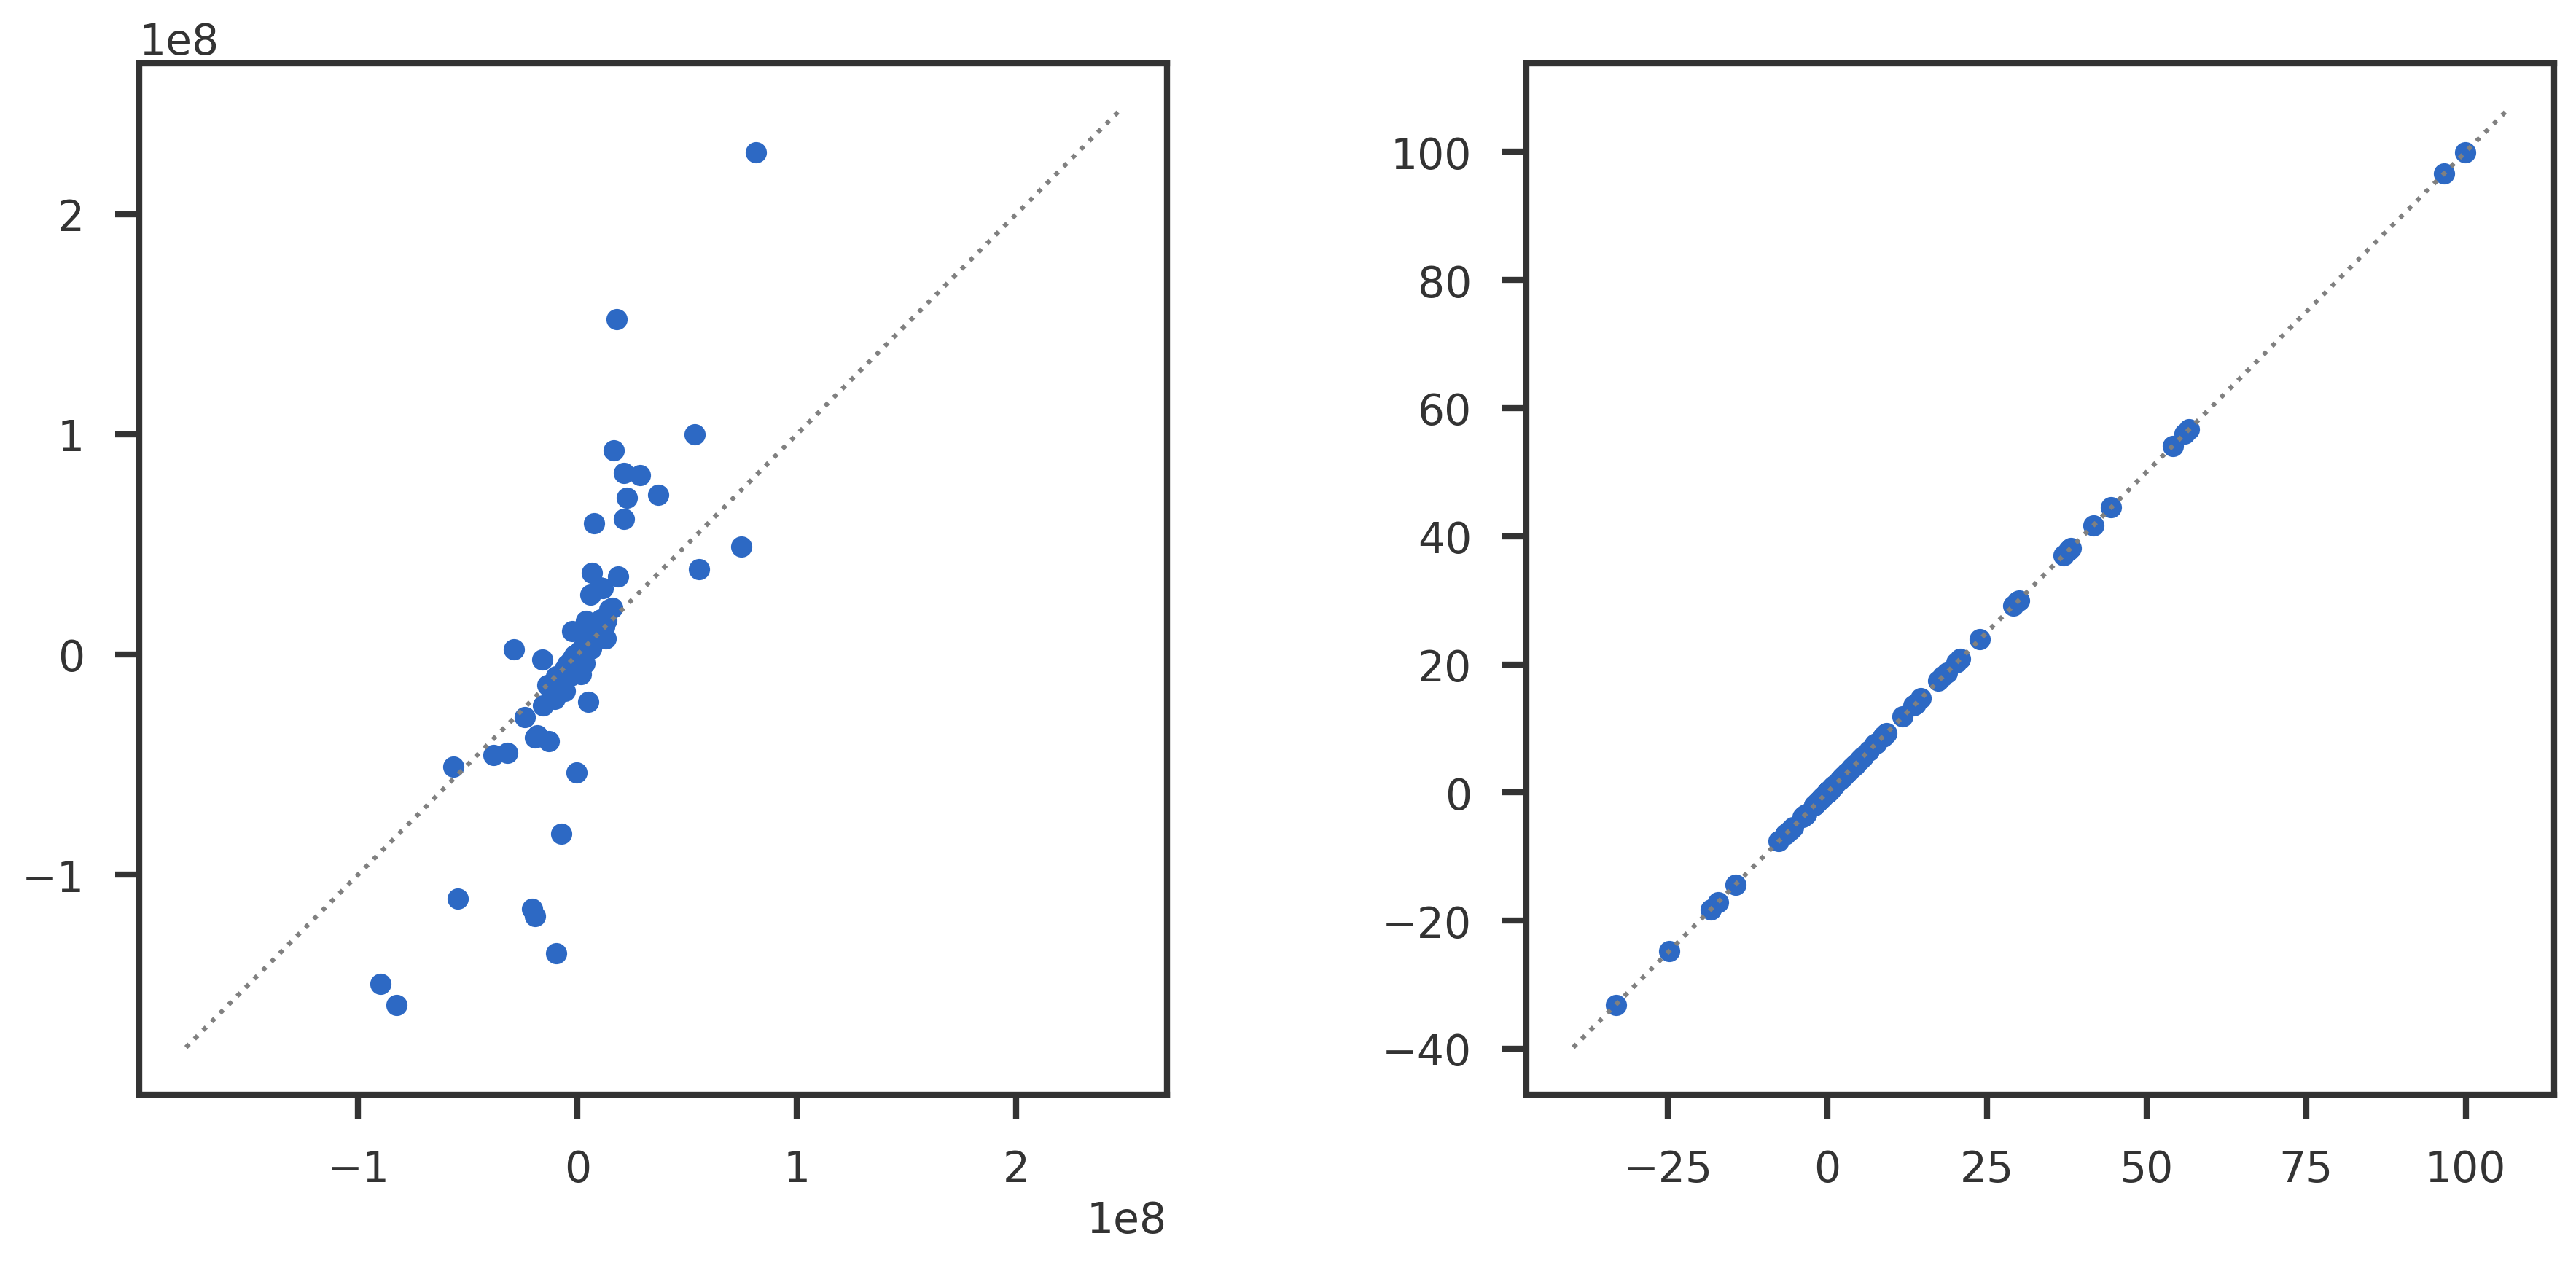

In [56]:
dk = 3

scale_fact = np.power(n, dk) / np.math.factorial(dk)
print(scale_fact)
fig = plt.figure(figsize = (12, 6))
ax  = [None for x in methods]
for i, meth in enumerate(methods):
    ax[i] = fig.add_subplot(1, len(methods), i + 1)
    ax[i].scatter(dhn[dk][meth]['x'], dha[dk][meth]['x'])
    mpl_utils.plot_diag(ax[i])
fig.tight_layout()
fig.subplots_adjust(wspace=0.35)
plt.show()

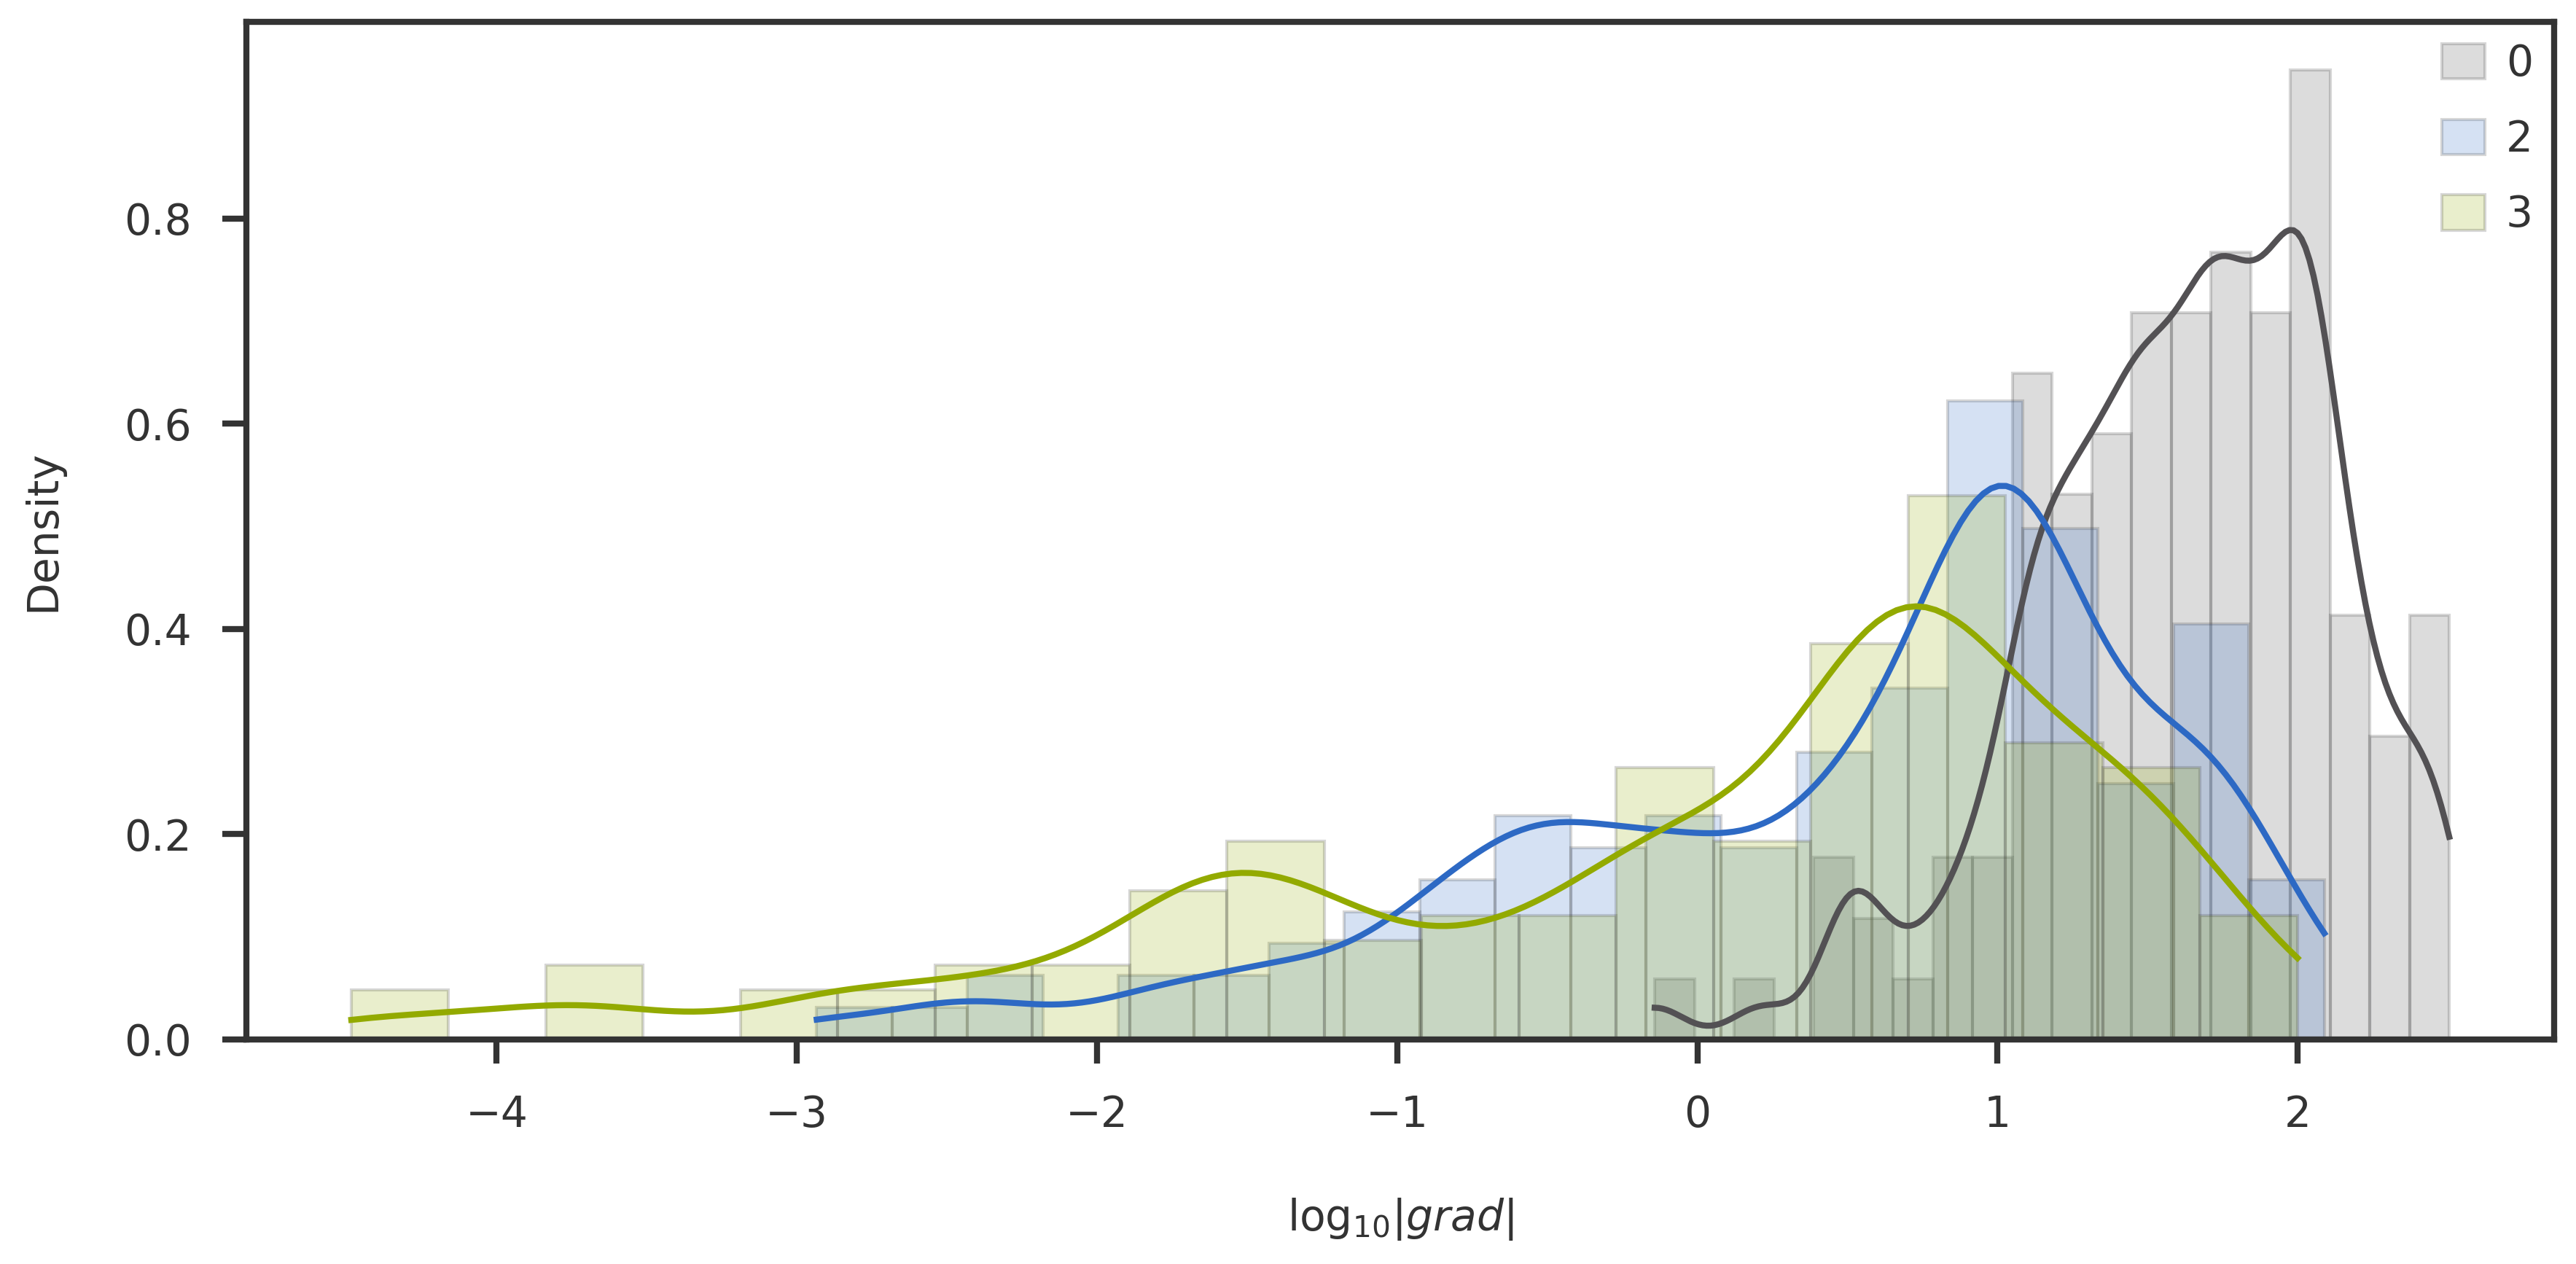

In [58]:
from scipy.stats import gaussian_kde as sp_gaussian_kde

def remove_outliers(data):
    quant3, quant1 = np.percentile(data, [75 ,25])
    iqr = quant3 - quant1
    xmin = quant1 - 1.5 * iqr
    xmax = quant3 + 1.5 * iqr
    Xkeep = np.array([x for x in data if (x >= xmin and x <= xmax)])
    return Xkeep

def density_plot(ax, data, label = '', color = 'k'):
    x = data.copy()
    #x = remove_outliers(data)
    xmin = np.min(x)
    xmax = np.max(x)
    kernel = sp_gaussian_kde(x)
    # smoothing
    kernel.covariance_factor = lambda : .2
    kernel._compute_covariance()
    
    xvals  = np.linspace(xmin, xmax, 200)
    density = kernel(xvals)
    ax.hist(x, density = True, label = label, color = color, alpha = 0.2)
    ax.plot(xvals, density, lw = 2, color = color)
    return

degree_colors = {
    3: "#93AA00",
    1: "#CC2529",
    2: "#2D69C4",
    'lasso': "#FFB300",
    'gradvi-wavelet': '#6B4C9A',
    0: '#535154'
}

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
meth = 'synthesis'
for dk in degrees:
    xvals = dha[dk][meth]['x']#[np.abs(data[dk].btrue) < 0.1]
    density_plot(ax1, np.log10(np.abs(xvals)), 
                 color = degree_colors[dk], label = f"{dk}")

ax1.legend()
ax1.set_ylabel("Density")
ax1.set_xlabel(r"$\log_{10}|grad|$")

#ax2.legend()
#mpl_utils.plot_diag(ax2)

fig.tight_layout()
# fig.subplots_adjust(wspace=0.35)
# utils.saveplot(fig, 'trendfiltering_simple_examples_wavelet_moving_average_init_properties')
plt.show()

In [45]:
dk = 2
data[dk].btrue[h_xd[dk] > 100]

array([0.56496453])

In [ ]:
priors = toy_priors.get_all(k = 10, skbase = 10., sparsity = 0.3)
for prior in priors:
    z, sj2, s2, dj = toy_data.get_normal_means(prior)

    ckwargs = {'scale': s2, 'd': dj, 'method': 'fssi-cubic', 'ngrid': 500}
    fkwargs = {'jac': False}

    nm = NMFromPost(z, prior, sj2, **ckwargs)
    x, x_bd, x_wd, x_s2d = nm.penalty_operator(jac = True)

    # Check derivatives
    print (f"{prior.prior_type} prior, derivative wrt b")
    dfdb_numeric = numerical_derivative(NMFromPost, 'penalty_operator', z, cpost_args = (prior, sj2),
                                        ckwargs = ckwargs, is_class_input = True, fkwargs = fkwargs,
                                        is_sum = True)
    np.testing.assert_allclose(x_bd, dfdb_numeric, atol = 1e-4, rtol = 1e-8)
    
    print (f"{prior.prior_type} prior, derivative wrt sj2")
    dfds2_numeric = numerical_derivative(NMFromPost, 'penalty_operator', s2, cpre_args = (z, prior),
                                     ckwargs = ckwargs, is_class_input = True, fkwargs = fkwargs,
                                     is_scale = True)
    np.testing.assert_allclose(x_s2d / dj, dfds2_numeric, atol = 1e-4, rtol = 1e-8)
    
    print (f"{prior.prior_type} prior, derivative wrt w")
    dfdw_numeric = numerical_derivative(NMFromPost, 'penalty_operator', prior, cpre_args = (z,),
                                        cpost_args = (sj2,), ckwargs = ckwargs, 
                                        is_class_input = True, fkwargs = fkwargs)
    np.testing.assert_allclose(np.sum(x_wd, axis = 0), dfdw_numeric, atol = 1e-4, rtol = 1e-8)

In [26]:
  
#     # Regression function
#     elif obj_method == 'synthesis':
#         lm = LinearModel(H, data[dk].y, b0, 
#                          s2true, prior, dj = dj, objtype = 'reparametrize')
#         h[dk] = lm.objective
#         h_xd[dk] = lm.bgrad
#         h_ad[dk] = lm.wmod_grad
#         h_s2d[dk] = lm.s2grad
        
#         dhdx = numerical_derivative(
#                 LinearModel, 'objective', b0, cpre_args = (H, data[dk].y),
#                 cpost_args = (s2true, prior), ckwargs = {'objtype': 'reparametrize', 'dj': dj}, 
#                 is_class_input = True, is_func_property = True)
#         print (f"{obj_method}, derivative wrt b for degree {dk}")
#         np.testing.assert_allclose(h_xd[dk], dhdx, atol = np.max(np.abs(dhdx)) / 1000, rtol = 1e-8)

analysis, derivative wrt x for degree 0
analysis, derivative wrt x for degree 1
analysis, derivative wrt x for degree 2


AssertionError: 
Not equal to tolerance rtol=1e-08, atol=2002.8

Mismatched elements: 52 / 128 (40.6%)
Max absolute difference: 76047.21273252
Max relative difference: 1.63985567
 x: array([-3.037948e+05,  5.979013e+05, -3.525773e+05,  6.185221e+05,
       -1.410589e+06,  1.573031e+06, -1.109008e+06,  2.605305e+05,
        4.252140e+05, -2.967288e+04, -1.358881e+06,  2.019684e+06,...
 y: array([-3.073722e+05,  6.104039e+05, -3.531129e+05,  6.213979e+05,
       -1.377988e+06,  1.528750e+06, -1.068576e+06,  2.365489e+05,
        3.510820e+05,  4.637433e+04, -1.360679e+06,  2.002804e+06,...